In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import optuna
import shap

d:\sme-hiring-assessment\sme-hiring-assessment\machine-learning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed=42

def seed_everything(seed=150):
    '''
    Set up the seed function
    '''
    np.random.seed(seed)

In [3]:
train=pd.read_csv('train_loan_data.csv')
test=pd.read_csv('test_loan_data.csv')
payment=pd.read_csv('train_payment_data.csv')
filter_off=pd.read_csv('filter_off.csv') # a set of data created to expose some of yield loss in the training data


### 1. Exploratory Data Analysis

In [4]:
#check for duplicates
num_duplicates = train.duplicated().sum()

print('Number of duuplicates:',num_duplicates)

# drop duplicates
train = train.drop_duplicates()

Number of duuplicates: 1723


In [5]:
train.head()

,loan_id,business_id,credit_officer_id,dismissal_description,acquisition_channel,sector,principal,total_owing_at_issue,application_number,applying_for_loan_number,loan_number,employee_count,approval_status,paid_late,total_recovered_on_time,total_recovered_15_dpd,cash_yield_15_dpd
0,860706,604923,131449.0,NaN,Friend,Beauty Fashion,300000.0,345500.0,1,1,1.0,1.0,Approved,False,345500.0,345500.0,45500.0
1,975605,604923,131449.0,NaN,Friend,Beauty Fashion,330000.0,380000.0,2,2,2.0,1.0,Approved,False,380000.0,380000.0,50000.0
2,126416,122438,NaN,Client does not have all of the requirements,Friend,Food Staple Goods,300000.0,NaN,1,1,NaN,1.0,Declined,False,NaN,NaN,NaN
3,127617,122438,108019.0,NaN,Friend,Food Staple Goods,200000.0,221100.0,2,1,1.0,1.0,Approved,False,221100.0,221100.0,21100.0
4,148416,122438,108019.0,NaN,Friend,Food Staple Goods,220000.0,243200.0,3,2,2.0,1.0,Approved,False,243200.0,243200.0,23200.0


In [6]:
test.head()

,loan_id,business_id,credit_officer_id,dismissal_description,acquisition_channel,sector,principal,total_owing_at_issue,application_number,applying_for_loan_number,loan_number,employee_count,approval_status,payment_status,paid_late,total_recovered_on_time,total_recovered_15_dpd,cash_yield_15_dpd
0,1003730,604923,131449,NaN,Friend,Beauty Fashion,350000.0,399500.0,3,3,3,1.0,Approved,Paid up,False,399500.0,399500.0,49500.0
1,986527,122438,279289,NaN,Friend,Food Staple Goods,1500000.0,1771000.0,30,27,27,1.0,Approved,Paid up,False,1771000.0,1771000.0,271000.0
2,985254,675619,279290,NaN,Sales Team,Metal and Woodworking,578400.0,648400.0,2,2,2,NaN,Approved,Paid up,False,648400.0,648400.0,70000.0
3,989887,312482,108022,NaN,Friend,Mobile Money Airtime,650000.0,768300.0,20,19,19,1.0,Approved,Written off,True,0.0,0.0,-650000.0
4,994582,654630,137987,NaN,Friend,Hospitality,594000.0,665900.0,3,3,3,NaN,Approved,Paid up,False,665900.0,665900.0,71900.0


In [7]:
payment.head()

,loan_id,paid_at,amount,transaction_type
0,834148,2023-11-25 17:44,200000.0,Deposit
1,4028,2019-02-09 16:55,1036300.0,NaN
2,4798,2019-04-25 15:50,1228500.0,NaN
3,2082,2018-08-22 10:41,50000.0,NaN
4,3802,2019-01-05 16:00,1384600.0,NaN


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23379 entries, 0 to 25101
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   loan_id                   23379 non-null  int64  
 1   business_id               23379 non-null  int64  
 2   credit_officer_id         22954 non-null  float64
 3   dismissal_description     515 non-null    object 
 4   acquisition_channel       23379 non-null  object 
 5   sector                    23379 non-null  object 
 6   principal                 23379 non-null  float64
 7   total_owing_at_issue      22307 non-null  float64
 8   application_number        23379 non-null  int64  
 9   applying_for_loan_number  23379 non-null  int64  
 10  loan_number               22307 non-null  float64
 11  employee_count            22566 non-null  float64
 12  approval_status           23379 non-null  object 
 13  paid_late                 23379 non-null  bool   
 14  total_recov

In [9]:
len(train.loan_id.unique())

23379

In [10]:
# group the loan_id by the payment made
grouped_payment = payment.groupby('loan_id')['amount'].sum().reset_index()

In [11]:
grouped_payment

,loan_id,amount
0,619,197600.0
1,1222,246100.0
2,1308,331500.0
3,1432,329700.0
4,1540,326200.0
...,...,...
22303,1003612,357000.0
22304,1004999,650300.0
22305,1005352,1150700.0
22306,1006476,672600.0


In [12]:
#merge grouped_payment to the train_data. This shows the total amount paid against the loan_id
train_payment= pd.merge(train, grouped_payment, on='loan_id') 

In [13]:
train_payment.head()

,loan_id,business_id,credit_officer_id,dismissal_description,acquisition_channel,sector,principal,total_owing_at_issue,application_number,applying_for_loan_number,loan_number,employee_count,approval_status,paid_late,total_recovered_on_time,total_recovered_15_dpd,cash_yield_15_dpd,amount
0,860706,604923,131449.0,NaN,Friend,Beauty Fashion,300000.0,345500.0,1,1,1.0,1.0,Approved,False,345500.0,345500.0,45500.0,345500.0
1,975605,604923,131449.0,NaN,Friend,Beauty Fashion,330000.0,380000.0,2,2,2.0,1.0,Approved,False,380000.0,380000.0,50000.0,380000.0
2,127617,122438,108019.0,NaN,Friend,Food Staple Goods,200000.0,221100.0,2,1,1.0,1.0,Approved,False,221100.0,221100.0,21100.0,221100.0
3,148416,122438,108019.0,NaN,Friend,Food Staple Goods,220000.0,243200.0,3,2,2.0,1.0,Approved,False,243200.0,243200.0,23200.0,243200.0
4,172015,122438,108019.0,NaN,Friend,Food Staple Goods,242000.0,269000.0,4,3,3.0,1.0,Approved,False,269000.0,269000.0,27000.0,269000.0


<Axes: title={'center': 'Count of Sectors'}, xlabel='sector'>

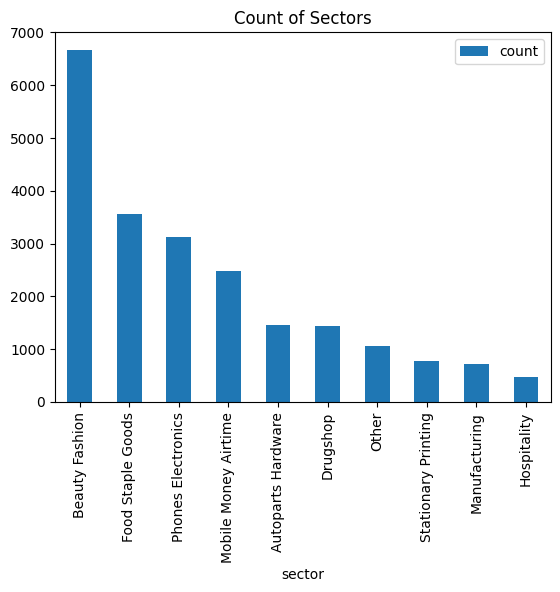

In [14]:
# Check sectore with most client
grouped_df = train.groupby('sector').size().reset_index(name='count').sort_values('count', ascending=False).head(10).reset_index(drop=True)
grouped_df.plot(kind='bar',x='sector',y='count',title='Count of Sectors')

In [15]:
grouped_df = train.groupby('sector').size().reset_index(name='count').sort_values('count', ascending=False).head(10).reset_index(drop=True)


<Axes: title={'center': 'Cash yield of sectors'}, xlabel='sector'>

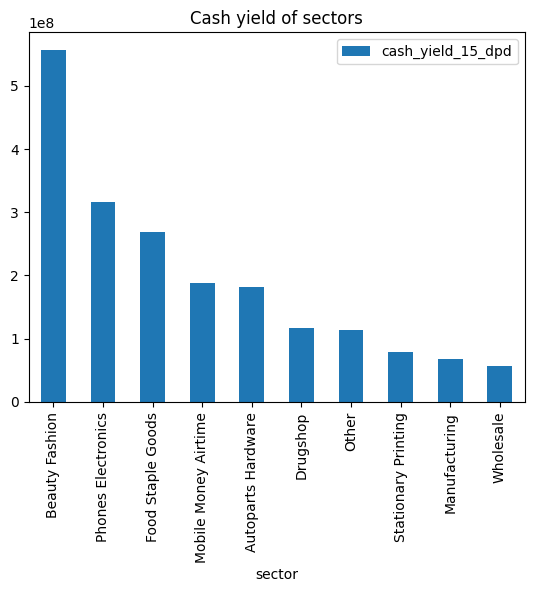

In [16]:
grouped_df= train.groupby('sector')['cash_yield_15_dpd'].sum().reset_index().sort_values('cash_yield_15_dpd', ascending=False).head(10).reset_index(drop=True)
grouped_df.plot(kind='bar',x='sector',y='cash_yield_15_dpd',title='Cash yield of sectors')

In [17]:
#Some cash yield statistics
train.describe().cash_yield_15_dpd

count    2.230700e+04
mean     9.489981e+04
std      1.053362e+05
min     -1.852900e+06
25%      4.070000e+04
50%      6.420000e+04
75%      1.084000e+05
max      1.426900e+06
Name: cash_yield_15_dpd, dtype: float64

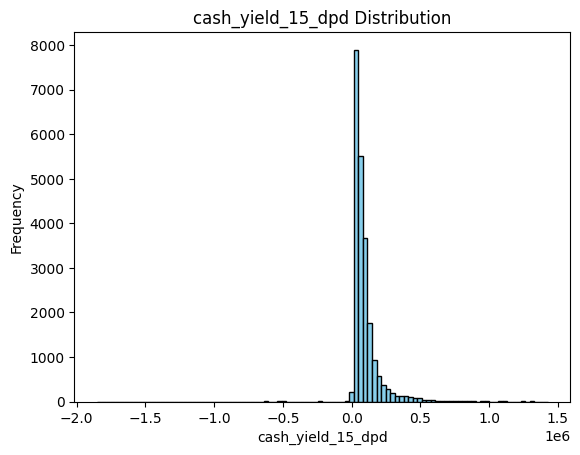

In [18]:
# A histogram plot of the cash yields
train['cash_yield_15_dpd'].plot(kind='hist', bins=100, color='skyblue', edgecolor='black')

# Show plot
plt.xlabel('cash_yield_15_dpd')
plt.title('cash_yield_15_dpd Distribution')
plt.show()

* The distribution of the yields is right-skewed, indicating that there are few large yields that pull the distribution to the right
* The median yield is around 6.420000e+04 while the mean is slightly higher (9.489981e+04) due to the influence of few large yields
* The range of yields is from -1.852900e+06 to 1.426900e+06, causing a high standard deviation of 1.426900e+06
* There are a few extreme yield greater than 1e6 pulling the yield higher.

In [19]:
#Pay late True to False proportion
Paid_late_True = train['paid_late'].mean() * 100
print('The percentage of loans with a late payment:',Paid_late_True)

The percentage of loans with a late payment: 2.852987724025835


*  The percentage of loans with a late payment is just 2.852987724025835. However, as seen in the test data set, loans with no late payment can still default.

In [20]:
#Proportion of paid_late but paid before 15dpd
train_paid_late=train[train.paid_late==True]
train_paid_late_full_payment=train_paid_late[train_paid_late.cash_yield_15_dpd>0]
proportion=(len(train_paid_late_full_payment)/len(train_paid_late))*100
print('The percentage of loans with a late payment but completed payment before 15days past due is',proportion)

The percentage of loans with a late payment but completed payment before 15days past due is 97.0014992503748


* About 97% of loans with at least a late payment (payment after 30 days) make full payment before the 15dpd

In [21]:
#create a field that shows if all payment were received or not
train_payment['full_collection'] = (train_payment.total_owing_at_issue <= train_payment.amount) 

In [22]:
# Proportion of those who did not pay before 15dpd but still ends up paying in full
past_15dpd=train_payment[train_payment.cash_yield_15_dpd<0]
past_15dpd_but_still_paid=past_15dpd[past_15dpd.full_collection==True]
proportion=(len(past_15dpd_but_still_paid)/len(past_15dpd))*100
print('The percentage of loans that did not complete payment before 15dpd but later paid in full is',proportion)

The percentage of loans that did not complete payment before 15dpd but later paid in full is 89.47368421052632


* In other words, only about 11% of loans that did not complete payment before 15dpd will end up not paying in full. Hence some payments can still be recovered even after 15dpd

In [23]:
# Proportion of paid_late who never paid in full i.e. loss of yield
after_15dpd_and_no_pay=past_15dpd[past_15dpd.full_collection==False]
proportion=(len(after_15dpd_and_no_pay)/len(train_paid_late))*100
print('The percentage of loans that paid late and did not pay in full is ',proportion)

The percentage of loans that paid late and did not pay in full is  0.29985007496251875


In [24]:
# Percentage of loans with yield loss at 15dpd
yield_loss=(len(train[train.cash_yield_15_dpd<0])/len(train[train.approval_status=='Approved']))*100
print('Only ',yield_loss,'% yield loss')

Only  0.08517505715694625 % yield loss


* From the EDAs, the following can be concluded:
    * The Beauty Fashion, Food staple Goods and Phones electronics are the sectors with the highest yields
    * The maximum yield received is 1.426900e+06
    * The most yeild loss is -1.852900e+06
    * The mean yield is  9.489981e+04
    * The rate or percentage of late payment is only 2.852%
    * Only 0.0851% did not pay up after 15dpd leading to a loss yield

* The following are the given information:
    * it is rare to relend to a customer that pays back more than 15 days late
    * Ultimately, yield is one of the most important metrics
* Therefore it is desired to know before hand what loan will lead to loss of yield and also potential loss of clients
* Loans not paid before 15dpd will lead to loss of yield and also potential loss of clients
* Therefore, the target variable is to determine if a loan will be paid before 15dpd or not. The task is therefore a binary classification task 

 

### 2. Features Engineering

In [25]:
def filter_off_to_expose_defaults(table_a, table_b):
    '''
    The function removes loans taken by a business after a yield loss in the training data
    The intention is to decipher the characteristics of the loans before default
    '''
    merged_df = pd.merge(table_a, table_b, on='business_id', how='inner')

    # Filter out rows where 'loan_number' is greater than 'threshold'. Threshold is the loan number with a yield loss
    filtered_df = merged_df[merged_df['loan_number'] <= merged_df['loan_number_threshold']]

    # Drop the 'threshold' column (no longer needed)
    filtered_df = filtered_df.drop('loan_number_threshold', axis=1)
    result_df = pd.concat([filtered_df, table_a[~table_a['business_id'].isin(table_b['business_id'])]])
    result_df = result_df.dropna(subset=['loan_number'])
    return result_df

In [26]:
train_filter=filter_off_to_expose_defaults(train,filter_off)

In [27]:
def sort_create_target(df):
    '''
    The function sorts the dataframe and creates a field for the defaults
    '''
    df=df.sort_values(by=['business_id','loan_number'])
    df['defaulted']=df.cash_yield_15_dpd <0
    return df

In [28]:
train_s=sort_create_target(train_filter)


In [29]:
train_s.head(10)

,loan_id,business_id,credit_officer_id,dismissal_description,acquisition_channel,sector,principal,total_owing_at_issue,application_number,applying_for_loan_number,loan_number,employee_count,approval_status,paid_late,total_recovered_on_time,total_recovered_15_dpd,cash_yield_15_dpd,defaulted
14373,5751,2055,5875.0,NaN,Friend,Manufacturing,380200.0,455400.0,1,1,1.0,4.0,Approved,False,455400.0,455400.0,75200.0,False
14374,74801,2055,18906.0,NaN,Friend,Manufacturing,399200.0,445300.0,2,2,2.0,4.0,Approved,True,0.0,445300.0,46100.0,False
14375,126809,2055,18906.0,NaN,Friend,Manufacturing,399200.0,465400.0,3,3,3.0,4.0,Approved,False,465400.0,465400.0,66200.0,False
14376,174980,2055,18906.0,NaN,Friend,Manufacturing,439100.0,492400.0,4,4,4.0,4.0,Approved,False,492400.0,492400.0,53300.0,False
14377,204915,2055,18906.0,NaN,Friend,Manufacturing,500000.0,560700.0,5,5,5.0,4.0,Approved,False,560700.0,560700.0,60700.0,False
14378,243411,2055,18906.0,NaN,Friend,Manufacturing,600000.0,672900.0,6,6,6.0,4.0,Approved,False,672900.0,672900.0,72900.0,False
14379,287624,2055,18906.0,NaN,Friend,Manufacturing,660000.0,740200.0,7,7,7.0,4.0,Approved,False,740200.0,740200.0,80200.0,False
14380,325607,2055,295227.0,NaN,Friend,Manufacturing,726000.0,814200.0,8,8,8.0,4.0,Approved,False,814200.0,814200.0,88200.0,False
14381,358375,2055,295227.0,NaN,Friend,Manufacturing,600000.0,672900.0,9,9,9.0,4.0,Approved,False,672900.0,672900.0,72900.0,False
14382,390215,2055,295227.0,NaN,Friend,Manufacturing,750000.0,841100.0,10,10,10.0,4.0,Approved,False,841100.0,841100.0,91100.0,False


In [30]:
def principal_percentage_change(group):
    '''
    The function calculates the percentage change in the principal
    for the last four loans of a business
    '''
    # Find the highest loan_number for this business_id
    highest_loan_number = group['loan_number'].max()
    
    # Filter to include only up to three loans before the highest loan_number
    # (We start with loan_number preceding the highest)
    recent_loans = group[group['loan_number'] <= highest_loan_number].tail(5)  # Select last 5 loans
    
    # Calculate the percentage change in the principal over the last three loans
    recent_loans['principal_pct_change'] = recent_loans['principal'].pct_change(periods=1) * 100
    pct_changes = recent_loans['principal'].pct_change(periods=1).dropna() * 100
    
    # We only want the percentage change for the three loans back from the highest
    return pct_changes.tolist() # Exclude the last loan (the highest loan_number itself)

# Apply the function to each group of 'business_id'
result = train_s.groupby('business_id').apply(principal_percentage_change)

C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\1109197357.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = train_s.groupby('business_id').apply(principal_percentage_change)


In [31]:
principal_change_0,principal_change_1,principal_change_2,principal_change_3=[], [], [], []
busines_id=[]

for i in result.keys():
    
    # Ensure the sublist has exactly 4 elements by padding with zeros
    # This corrects for businesses with less than 5 loans
   
    padded_sublist = result[i] + [0] * (4 - len(result[i]))

    # Append each element to its respective new list
    principal_change_3.append(padded_sublist[0])
    principal_change_2.append(padded_sublist[1])
    principal_change_1.append(padded_sublist[2])
    principal_change_0.append(padded_sublist[3])
    busines_id.append(i)

In [32]:
def default_paid_late(group):
    '''
    The function extracts the number of times a business
    has defaulted (yield loss) or paid late
    '''
    paid_late = group['paid_late'].sum().tolist()
    default=group['defaulted'].sum().tolist()
    return paid_late,default

def process_paid_late_default(paid_late):
    '''
    The function creates a dataframe of the paid_late and 
    defaulted variables.
    '''
    df = pd.DataFrame(paid_late).reset_index()
    df[0] = df[0].apply(lambda x: str(x))
        # Remove parentheses and split the second column
    df[['paid_late','number_of_defaults']] = df[0].str.strip('()').str.split(', ', expand=True)
    # Convert the new columns to integers (optional)
    df['paid_late'] = df['paid_late'].astype(int)
    df['number_of_defaults'] = df['number_of_defaults'].astype(int)
    # Drop the original second column if needed
    df = df.drop(0, axis=1)
    return df
    

In [33]:
paid_late_default= train_s.groupby('business_id').apply(default_paid_late)
df_paid_late_default=process_paid_late_default(paid_late_default)

C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\1252836018.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  paid_late_default= train_s.groupby('business_id').apply(default_paid_late)


In [34]:
df_paid_late_default

,business_id,paid_late,number_of_defaults
0,2055,1,0
1,2229,9,3
2,3066,1,1
3,5104,0,0
4,5467,0,0
...,...,...,...
1864,696674,0,0
1865,699641,0,0
1866,700419,0,0
1867,702157,0,0


* The table above shows that some businesses were given loans even after a failure to pay 15dpd (e.g. business_id 2229)

In [35]:
# The payment information is merged to the training data
# This allows for the extraction of payments pattern
payment_loanid=payment.merge(train_s,on='loan_id')

In [36]:
def number_of_payments(group):
    '''
    The function extracts the number of payment made for the last three loans
    '''
    # Find the highest loan_number for this business_id
    highest_loan_number = group['loan_number'].max()
    # Filter to include only up to three loans before the highest loan_number
    # (We start with loan_number preceding the highest)
    recent_loans = group[group['loan_number'] < highest_loan_number].tail(4) 
    number_of_payment = recent_loans['count']
    
    return number_of_payment.tolist() 

# Step 3: Apply this logic to each group of 'business_id'
check = payment_loanid.groupby(['business_id','loan_number']).size().reset_index(name='count')
grouped_df = check.groupby('business_id').tail(5)
result = grouped_df.groupby('business_id').apply(number_of_payments)

C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\1032712981.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = grouped_df.groupby('business_id').apply(number_of_payments)


In [37]:
result

business_id
2055      [3, 5, 5, 5]
2229      [6, 4, 6, 4]
3066      [4, 2, 1, 5]
5104      [1, 1, 1, 1]
5467      [3, 2, 3, 6]
              ...     
696674              []
699641              []
700419              []
702157              []
708308              []
Length: 1869, dtype: object

In [38]:
payment_count_0,payment_count_1,payment_count_2,payment_count_3=[], [], [], []

for i in result.keys():
    
    # Ensure the sublist has exactly 4 elements by padding with zeros
   
    padded_sublist = result[i] + [0] * (4 - len(result[i]))

    # Append each element to its respective new list

    payment_count_3.append(padded_sublist[0])
    payment_count_2.append(padded_sublist[1])
    payment_count_1.append(padded_sublist[2])
    payment_count_0.append(padded_sublist[3])


In [39]:

def create_target_variable(group):
    '''
    This function creates the target feature,
    The target is to predict if there will be yield loss
    in the next loan 
    '''
    # Find the highest loan_number for this business_id
    highest_loan_number = group['loan_number'].max()
    # Filter for the highest loan number
    recent_loans = group[group['loan_number'] == highest_loan_number]
    target_variable=recent_loans[['business_id','loan_number','defaulted']].reset_index(drop=True)
    return target_variable


target_variable = train_s.groupby('business_id').apply(create_target_variable)
target_variable=target_variable[['business_id','loan_number','defaulted']].reset_index(drop=True)

C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\196948249.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  target_variable = train_s.groupby('business_id').apply(create_target_variable)


In [40]:
def list_to_dataframe(lists):
    '''
    Merges all the engineered features into a dataframe
    '''
    df=pd.DataFrame()
    for i in lists:
        j=pd.DataFrame(i)
        df=pd.concat([df,j],axis=1)
    df.columns=['principal_change_0','principal_change_1','principal_change_2',
                'principal_change_3','payment_count_0','payment_count_1','payment_count_2','payment_count_3']
    return df

In [41]:
lists=[principal_change_0,principal_change_1,principal_change_2,principal_change_3,
       payment_count_0,payment_count_1,payment_count_2,payment_count_3
       
       ]
df_list=list_to_dataframe(lists)

In [42]:
new_df=pd.concat([df_list,target_variable],axis=1)

In [43]:
new_df[new_df['defaulted']==True]

,principal_change_0,principal_change_1,principal_change_2,principal_change_3,payment_count_0,payment_count_1,payment_count_2,payment_count_3,business_id,loan_number,defaulted
1,-26.226667,0.000000,0.000000,0.000000,4,6,4,6,2229,12.0,True
2,52.568232,73.194363,-0.467563,20.365811,5,1,2,4,3066,9.0,True
11,10.000000,0.000000,50.000000,25.000000,3,5,1,2,12457,7.0,True
23,0.000000,50.000000,33.333333,36.363636,0,2,1,2,21904,4.0,True
32,2.000374,6.980000,11.141984,12.468750,1,1,1,2,26264,26.0,True
49,3.001679,1.991008,9.996468,9.998705,2,3,2,1,34984,17.0,True
58,5.001670,4.998442,4.870077,5.002145,1,1,1,1,39492,16.0,True
85,1.998673,2.013536,1.984469,1.997712,9,9,6,9,53068,23.0,True
230,9.481060,9.995183,9.986755,9.994172,17,19,19,16,135606,7.0,True
237,10.007064,8.066158,11.742963,18.817568,1,1,1,1,139302,7.0,True


### 3. Model Building and Evaluation

In [44]:
X=new_df.drop(['business_id','defaulted'],axis=1)
y=new_df['defaulted']

* One of the requirements of the task is that the approach must be able to allow for the addition of new input.
* Hence, the imputer will be employed to allow the addition of both numerical and non- numerical variables without breaking the code
* Also, because of the severe class imbalance observed in the EDA (0.08 to 99.02), the Synthetic Minority Over-sampling TEchnique (SMOTE) is used

In [45]:
# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Handle imbalance with SMOTE
smote = SMOTE(random_state=seed)

# Define 3-Fold Cross-Validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
model = xgb.XGBClassifier(random_state=seed)


In [46]:
def trainer(model,X,y,cv):
    '''
    The function trains and cross-validate the models
    '''

    cv_reports = []
    roc_aucs = []
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y), 1):
        X_fold_train = X_imputed.iloc[train_idx]
        X_fold_valid = X_imputed.iloc[valid_idx]
        y_fold_train = y.iloc[train_idx]
        y_fold_valid = y.iloc[valid_idx]
        # Apply SMOTE only on the training data of this fold
        X_fold_train_smote, y_fold_train_smote = smote.fit_resample(X_fold_train, y_fold_train)
        
        # Train the model on the SMOTE-balanced fold
        model.fit(X_fold_train_smote, y_fold_train_smote)
        
        # Predict on the validation fold
        y_fold_pred = model.predict(X_fold_valid)
        y_fold_pred_prob = model.predict_proba(X_fold_valid)[:, 1]
        
        # Calculate and store the classification report for this fold
        report = classification_report(y_fold_valid, y_fold_pred, output_dict=True)
        cv_reports.append(report)
        
        # Calculate and store the ROC AUC score for this fold
        roc_auc = roc_auc_score(y_fold_valid, y_fold_pred_prob)
        roc_aucs.append(roc_auc)
        
        # Print classification report for the current fold
        print(f"Fold {fold} Classification Report:")
        print(classification_report(y_fold_valid, y_fold_pred))
        print(f"Fold {fold} ROC AUC: {roc_auc:.4f}")
        print("-" * 50)

    # Summary of CV results
    print(f"Mean ROC AUC across folds: {np.mean(roc_aucs):.4f}")


In [47]:
trainer(model,X_imputed,y,cv)

Fold 1 Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99       618
        True       0.00      0.00      0.00         5

    accuracy                           0.98       623
   macro avg       0.50      0.49      0.50       623
weighted avg       0.98      0.98      0.98       623

Fold 1 ROC AUC: 0.5990
--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99       617
        True       0.00      0.00      0.00         6

    accuracy                           0.98       623
   macro avg       0.50      0.49      0.49       623
weighted avg       0.98      0.98      0.98       623

Fold 2 ROC AUC: 0.3941
--------------------------------------------------
Fold 3 Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99       617

* The support for the True class is very small compared to the False class (617 to 6). Hence, the model struggles to predict the True class

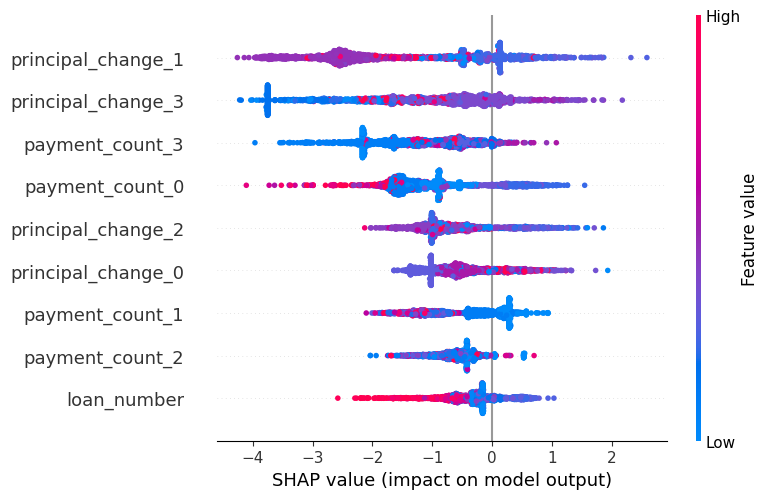

In [48]:
# A view at the feature importance
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_imputed)

# Plot summary of feature importances
shap.summary_plot(shap_values, X_imputed,)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

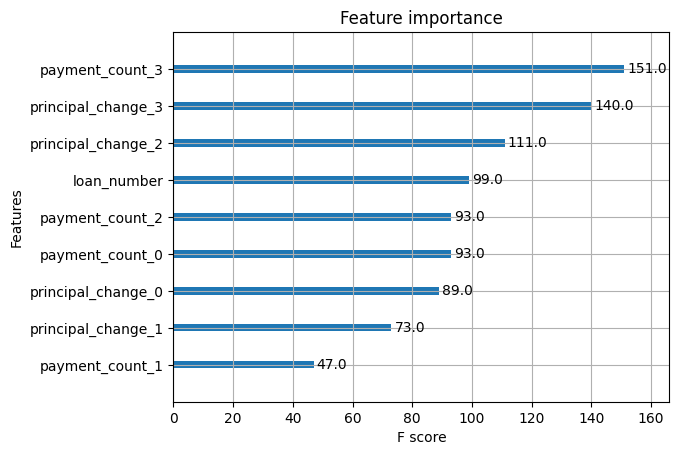

In [49]:
xgb.plot_importance(model, importance_type='weight')

##### 3a. Hyper-parameters tunning using optuna

In [50]:
def objective(trial):
    '''
    The function defines Objective Function for Optuna
    '''
    seed_everything(seed) # enforce reproducibility
    # XGBoost hyperparameters to be tuned
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'booster': 'gbtree',
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 10.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }
    
    # Cross-validation
    xgb_model = xgb.XGBClassifier(**params,random_state=seed)
    
    scores = cross_val_score(xgb_model, X_imputed, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    print(scores)
    return scores.mean()  # Return the mean AUC score

In [51]:
# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=seed))
study.optimize(objective, n_trials=30, timeout=600)  # Tune for 30 trials or 10 minutes

# Get the best hyperparameters
print("Best hyperparameters:", study.best_trial.params)

# Train XGBoost model with best hyperparameters
best_params = study.best_trial.params
model_fine_tuned = xgb.XGBClassifier(**best_params, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss',random_state=seed)


[I 2024-09-18 10:04:37,602] A new study created in memory with name: no-name-9f4578b8-8422-47b7-9514-26cb73b14f4f
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://g

[0.51375405 0.41518098 0.47866018]


C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.su

[0.27734628 0.32603998 0.38776337]


C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.su

[0.51747573 0.44421934 0.37250135]


C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.su

[0.5 0.5 0.5]


C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.su

[0.51391586 0.35210697 0.42585089]


C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.su

[0.28365696 0.5        0.39883847]
[0.55436893 0.33752026 0.5189087 ]
[0.5        0.48851972 0.44057266]


C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.su

[0.4223301  0.39289573 0.41139924]
[0.50307443 0.44867639 0.4126148 ]


C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.su

[0.5 0.5 0.5]
[0.5 0.5 0.5]


C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.su

[0.5        0.5        0.41423555]
[0.5        0.5        0.47866018]


C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.su

[0.56812298 0.41234468 0.37263641]
[0.5 0.5 0.5]


[I 2024-09-18 10:04:53,451] Trial 16 finished with value: 0.4532467362171064 and parameters: {'lambda': 0.11505031213072171, 'alpha': 0.09538927906853832, 'learning_rate': 0.02725782387251979, 'n_estimators': 435, 'max_depth': 6, 'min_child_weight': 6, 'gamma': 0.425188213719246, 'subsample': 0.5136095131955984, 'colsample_bytree': 0.5065896071904618}. Best is trial 3 with value: 0.5.
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., l

[0.50695793 0.4593463  0.39343598]
[0.5        0.5        0.41288493]


[I 2024-09-18 10:04:53,747] Trial 18 finished with value: 0.564391591005649 and parameters: {'lambda': 2.5071513394644622, 'alpha': 0.2312876312528823, 'learning_rate': 0.01654619613791643, 'n_estimators': 442, 'max_depth': 7, 'min_child_weight': 8, 'gamma': 0.7983105440459775, 'subsample': 0.722295168464534, 'colsample_bytree': 0.9025554266033063}. Best is trial 18 with value: 0.564391591005649.
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_

[0.66116505 0.61980011 0.41220962]
[0.66877023 0.5606429  0.37466234]


[I 2024-09-18 10:04:54,070] Trial 20 finished with value: 0.4894286128900848 and parameters: {'lambda': 1.34186778291813, 'alpha': 0.06375360520231377, 'learning_rate': 0.015545025762510342, 'n_estimators': 435, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 0.6199926771882378, 'subsample': 0.6973639320278461, 'colsample_bytree': 0.9969213925248545}. Best is trial 18 with value: 0.564391591005649.
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugge

[0.58430421 0.45975149 0.42423015]
[0.57847896 0.57279849 0.38317126]


[I 2024-09-18 10:04:54,375] Trial 22 finished with value: 0.5238410445503962 and parameters: {'lambda': 0.9692257818350817, 'alpha': 0.043403625660118815, 'learning_rate': 0.03492834765732192, 'n_estimators': 391, 'max_depth': 8, 'min_child_weight': 9, 'gamma': 0.12709365089120067, 'subsample': 0.7386784699005607, 'colsample_bytree': 0.964058116449869}. Best is trial 18 with value: 0.564391591005649.
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugg

[0.6368932  0.52714749 0.40748244]
[0.55728155 0.5        0.41504592]


[I 2024-09-18 10:04:54,692] Trial 24 finished with value: 0.49687696146052424 and parameters: {'lambda': 0.7028172523679277, 'alpha': 0.038936508824020145, 'learning_rate': 0.0348615754434986, 'n_estimators': 412, 'max_depth': 8, 'min_child_weight': 8, 'gamma': 0.06449386726391108, 'subsample': 0.6631604068114754, 'colsample_bytree': 0.9617368773881144}. Best is trial 18 with value: 0.564391591005649.
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sug

[0.61407767 0.47771475 0.39883847]
[0.65339806 0.5        0.43206375]


[I 2024-09-18 10:04:55,056] Trial 26 finished with value: 0.47866018368449487 and parameters: {'lambda': 3.822496721294793, 'alpha': 0.881232187075888, 'learning_rate': 0.01808719225054775, 'n_estimators': 460, 'max_depth': 7, 'min_child_weight': 10, 'gamma': 0.01337658778943493, 'subsample': 0.5927069520870604, 'colsample_bytree': 0.8842645340580617}. Best is trial 18 with value: 0.564391591005649.
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugge

[0.5        0.5        0.43598055]
[0.5        0.69705565 0.41288493]


C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\4087342044.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.su

[0.5        0.5        0.47866018]
[0.5        0.5        0.41585629]
Best hyperparameters: {'lambda': 2.5071513394644622, 'alpha': 0.2312876312528823, 'learning_rate': 0.01654619613791643, 'n_estimators': 442, 'max_depth': 7, 'min_child_weight': 8, 'gamma': 0.7983105440459775, 'subsample': 0.722295168464534, 'colsample_bytree': 0.9025554266033063}


In [52]:
# To avoid always having differen parameters, the best parameters when testing will be used
best_params={'lambda': 0.1271870391128985, 'alpha': 0.0049287529015657324, 'learning_rate': 0.015746853932778596, 'n_estimators': 282, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 3.3130134901847033, 'subsample': 0.7474471006975164, 'colsample_bytree': 0.5401847428285809}

In [53]:
model_fine_tuned = xgb.XGBClassifier(**best_params, objective='binary:logistic', use_label_encoder=False, eval_metric='logloss',random_state=seed)
trainer(model_fine_tuned,X_imputed,y,cv)

d:\sme-hiring-assessment\sme-hiring-assessment\machine-learning\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:04:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.97      0.98       618
        True       0.00      0.00      0.00         5

    accuracy                           0.96       623
   macro avg       0.50      0.48      0.49       623
weighted avg       0.98      0.96      0.97       623

Fold 1 ROC AUC: 0.5453
--------------------------------------------------


d:\sme-hiring-assessment\sme-hiring-assessment\machine-learning\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:04:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.97      0.98       617
        True       0.00      0.00      0.00         6

    accuracy                           0.96       623
   macro avg       0.50      0.48      0.49       623
weighted avg       0.98      0.96      0.97       623

Fold 2 ROC AUC: 0.4873
--------------------------------------------------


d:\sme-hiring-assessment\sme-hiring-assessment\machine-learning\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:04:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99       617
        True       0.00      0.00      0.00         6

    accuracy                           0.98       623
   macro avg       0.50      0.50      0.50       623
weighted avg       0.98      0.98      0.98       623

Fold 3 ROC AUC: 0.4099
--------------------------------------------------
Mean ROC AUC across folds: 0.4808


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

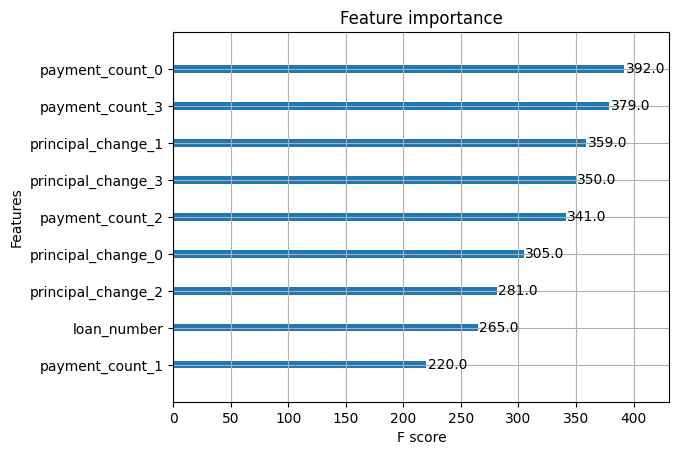

In [54]:
# check the feature_importance after hyper-parameter fine-tuning
xgb.plot_importance(model_fine_tuned, importance_type='weight')

##### 3b. Model Evaluation on Train and Test dataset, cv=3

In [55]:
# Model Evaluation and Fine-tuning on Test set 
# The same data preparation process will be followed
test_1=test.drop('payment_status',axis=1)
train_test=pd.concat([train,test_1]).reset_index(drop=True)

In [56]:
train_test_s=sort_create_target(train_test)
result = train_test_s.groupby('business_id').apply(principal_percentage_change)

C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\1212845992.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = train_test_s.groupby('business_id').apply(principal_percentage_change)


In [57]:
principal_change_0,principal_change_1,principal_change_2,principal_change_3=[], [], [], []
busines_id=[]

for i in result.keys():
    
    # Ensure the sublist has exactly 4 elements by padding with zeros
   
    padded_sublist = result[i] + [0] * (4 - len(result[i]))

    # Append each element to its respective new list
    principal_change_3.append(padded_sublist[0])
    principal_change_2.append(padded_sublist[1])
    principal_change_1.append(padded_sublist[2])
    principal_change_0.append(padded_sublist[3])
    busines_id.append(i)

In [58]:
paid_late_default= train_test_s.groupby('business_id').apply(default_paid_late)
df_paid_late_default=process_paid_late_default(paid_late_default)

C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\1355318464.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  paid_late_default= train_test_s.groupby('business_id').apply(default_paid_late)


In [59]:
payment_loanid=payment.merge(train_test_s,on='loan_id')
check = payment_loanid.groupby(['business_id','loan_number']).size().reset_index(name='count')
grouped_df = check.groupby('business_id').tail(5)
result = grouped_df.groupby('business_id').apply(number_of_payments)

C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\245172319.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = grouped_df.groupby('business_id').apply(number_of_payments)


In [60]:
payment_count_0,payment_count_1,payment_count_2,payment_count_3=[], [], [],[]

for i in result.keys():
    
    # Ensure the sublist has exactly 4 elements by padding with zeros
   
    padded_sublist = result[i] + [0] * (4 - len(result[i]))

    # Append each element to its respective new list
    payment_count_3.append(padded_sublist[0])
    payment_count_2.append(padded_sublist[1])
    payment_count_1.append(padded_sublist[2])
    payment_count_0.append(padded_sublist[3])


In [61]:
target_variable = train_test_s.groupby('business_id').apply(create_target_variable)
target_variable=target_variable[['business_id','loan_number','defaulted']].reset_index(drop=True)

C:\Users\oluwatobi.afolabi\AppData\Local\Temp\ipykernel_11612\2535656168.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  target_variable = train_test_s.groupby('business_id').apply(create_target_variable)


In [62]:
lists=[principal_change_0,principal_change_1,principal_change_2,principal_change_3,
       payment_count_0,payment_count_1,payment_count_2,payment_count_3
       
       ]
df_list=list_to_dataframe(lists)

In [63]:
new_df=pd.concat([df_list,target_variable],axis=1)
new_df[new_df['defaulted']==True]

,principal_change_0,principal_change_1,principal_change_2,principal_change_3,payment_count_0,payment_count_1,payment_count_2,payment_count_3,business_id,loan_number,defaulted
22,2.001837,10.000000,10.000000,22.727273,1,1,1,1,21480,20.0,True
49,4.997574,9.998221,10.000000,5.000000,1,2,4,1,34984,37.0,True
52,4.999088,9.620000,5.366676,9.998455,1,1,1,1,35845,15.0,True
68,32.700000,-20.000000,7.913669,9.881423,2,3,2,5,44908,44.0,True
91,1.999147,2.000000,16.349656,2.002064,8,4,10,12,56486,34.0,True
...,...,...,...,...,...,...,...,...,...,...,...
1838,0.000000,0.000000,0.000000,45.970000,0,0,0,0,685978,2.0,True
1846,0.000000,0.000000,0.000000,10.000000,0,0,0,0,688057,2.0,True
1852,0.000000,0.000000,0.000000,10.000000,0,0,0,0,690779,2.0,True
1859,0.000000,2.089765,0.000000,8.307613,0,0,0,2,692326,3.0,True


In [64]:
X=new_df.drop(['business_id','defaulted'],axis=1)
y=new_df['defaulted']
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

In [65]:
trainer(model_fine_tuned,X_imputed,y,cv)

d:\sme-hiring-assessment\sme-hiring-assessment\machine-learning\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:05:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.91      0.91       568
        True       0.13      0.15      0.14        55

    accuracy                           0.84       623
   macro avg       0.52      0.53      0.53       623
weighted avg       0.85      0.84      0.84       623

Fold 1 ROC AUC: 0.6138
--------------------------------------------------
Fold 2 Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.92      0.92       567
        True       0.15      0.14      0.15        56

    accuracy                           0.85       623
   macro avg       0.53      0.53      0.53       623
weighted avg       0.85      0.85      0.85       623

Fold 2 ROC AUC: 0.5840
--------------------------------------------------


d:\sme-hiring-assessment\sme-hiring-assessment\machine-learning\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:05:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\sme-hiring-assessment\sme-hiring-assessment\machine-learning\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:05:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.82      0.87       567
        True       0.14      0.29      0.18        56

    accuracy                           0.77       623
   macro avg       0.53      0.55      0.53       623
weighted avg       0.85      0.77      0.81       623

Fold 3 ROC AUC: 0.6402
--------------------------------------------------
Mean ROC AUC across folds: 0.6127


##### 3c. Model Evaluation on Test Dataset. cv=3

In [66]:
#Next Step Select for X and Y where business_id is in test ONLY
new_df_x_test =  new_df[new_df['business_id'].isin(test['business_id'])]

In [67]:
X_t=new_df_x_test.drop(['business_id','defaulted'],axis=1)
y_t=new_df['defaulted']
X_imputed_t = pd.DataFrame(imputer.fit_transform(X_t), columns=X_t.columns)

In [68]:
trainer(model_fine_tuned,X_imputed_t,y_t,cv)

d:\sme-hiring-assessment\sme-hiring-assessment\machine-learning\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:05:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 1 Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.91      0.91       568
        True       0.13      0.15      0.14        55

    accuracy                           0.84       623
   macro avg       0.52      0.53      0.53       623
weighted avg       0.85      0.84      0.84       623

Fold 1 ROC AUC: 0.6138
--------------------------------------------------


d:\sme-hiring-assessment\sme-hiring-assessment\machine-learning\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:05:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 2 Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.92      0.92       567
        True       0.15      0.14      0.15        56

    accuracy                           0.85       623
   macro avg       0.53      0.53      0.53       623
weighted avg       0.85      0.85      0.85       623

Fold 2 ROC AUC: 0.5840
--------------------------------------------------


d:\sme-hiring-assessment\sme-hiring-assessment\machine-learning\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:05:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fold 3 Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.82      0.87       567
        True       0.14      0.29      0.18        56

    accuracy                           0.77       623
   macro avg       0.53      0.55      0.53       623
weighted avg       0.85      0.77      0.81       623

Fold 3 ROC AUC: 0.6402
--------------------------------------------------
Mean ROC AUC across folds: 0.6127


#### 4. Conclusion

* The proposed model achieved a mean ROC AUC of 61% on the test dataset (cv=3). Although, the performance of the model can be improved, its ability to detect some potential yield loss is commendable. This can be used by the officers during due deligence
* The performance of the model in detecting yield-loss will improve as more instances of yield loss is exposed to it. This explains the improvement seen in the mean ROC AUC from 48% in the training dataset to 61% in the training and testing datasets.

### 5. Next Steps

* The following are the proposed next steps 
    * The model predicts whether there will be a yield loss or not given the history of the business, this can be taken a step further to predict the likelihood of payment after 15dpd
    * The task has been treated as a classification task (True or False), it might be better to output probabilities of default instead of an absolute True or False. This hypothesis should be tested
    * The data is highly skewed. To improve the quality of prediction, more data (especially those with defaults) should be added
    * Including the days between successive loans feature might help to understand the behaviour of a business much better.